In [33]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../data/KDDTrain+.txt", header=None)

column_names = [
        "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
        "wrong_fragment","urgent","hot","num_failed_logins","logged_in",
        "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
        "num_shells","num_access_files","num_outbound_cmds","is_host_login",
        "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
        "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
        "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
        "dst_host_same_srv_rate","dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
        "dst_host_serror_rate","dst_host_srv_serror_rate",
        "dst_host_rerror_rate","dst_host_srv_rerror_rate",
        "label","difficulty"
    ]

train_df.columns = column_names


In [34]:
train_df=train_df.drop(columns=['difficulty'])

In [35]:
train_df['binary_label']=train_df['label'].apply(lambda x:0 if x=='normal' else 1)

In [36]:
X = train_df.drop(columns=["label", "binary_label"])
y = train_df["binary_label"]

In [37]:
categorical_cols = ["protocol_type", "service", "flag"]

X = pd.get_dummies(X, columns=categorical_cols)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [39]:
X_normal = X_scaled[y == 0]


In [40]:
# now we have to use the isolation forest for detecting the anamoly because it works nicely on high dimensional

In [41]:
from sklearn.ensemble import IsolationForest
iso_model=IsolationForest(
    n_estimators=200,
    contamination=0.1,
    random_state=42
)
iso_model.fit(X_normal)
y_pred=iso_model.predict(X_scaled)

In [42]:
y_pred = np.where(y_pred == 1, 0, 1)
#here replacing the prediction as through the isolation forest it gives the in the form of 1(normal) and -1(anamoly)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[60608  6735]
 [ 3521 55109]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     67343
           1       0.89      0.94      0.91     58630

    accuracy                           0.92    125973
   macro avg       0.92      0.92      0.92    125973
weighted avg       0.92      0.92      0.92    125973



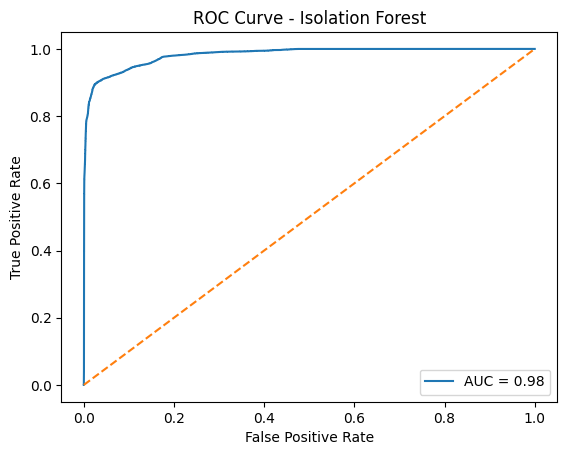

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

scores = iso_model.decision_function(X_scaled)

fpr, tpr, _ = roc_curve(y, -scores)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.legend()
plt.show()


That means that even when the False Positive Rate is very low, the model is still able to achieve a very high True Positive Rate. In simple terms, this indicates that the system can detect most of the attacks while generating very few false alarms. Such performance reflects excellent model behavior, as it successfully balances strong detection capability with minimal incorrect alerts.


In [45]:
for c in [0.1, 0.2, 0.3, 0.4, 0.5]:
    model = IsolationForest(n_estimators=200, contamination=c, random_state=42)
    model.fit(X_normal)
    preds = model.predict(X_scaled)
    preds = np.where(preds == 1, 0, 1)
    print(f"Contamination: {c}")
    print(classification_report(y, preds))
    print("------")


Contamination: 0.1
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     67343
           1       0.89      0.94      0.91     58630

    accuracy                           0.92    125973
   macro avg       0.92      0.92      0.92    125973
weighted avg       0.92      0.92      0.92    125973

------
Contamination: 0.2
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     67343
           1       0.81      0.98      0.89     58630

    accuracy                           0.88    125973
   macro avg       0.89      0.89      0.88    125973
weighted avg       0.90      0.88      0.88    125973

------
Contamination: 0.3
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     67343
           1       0.74      0.99      0.85     58630

    accuracy                           0.84    125973
   macro avg       0.87      0.85      0.83    125973
wei

In [46]:
from sklearn.svm import OneClassSVM
ocsvm=OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.1
)
ocsvm.fit(X_normal)
preds = ocsvm.predict(X_scaled)
preds = np.where(preds == 1, 0, 1)

print(confusion_matrix(y, preds))
print(classification_report(y, preds))

[[60612  6731]
 [ 3551 55079]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     67343
           1       0.89      0.94      0.91     58630

    accuracy                           0.92    125973
   macro avg       0.92      0.92      0.92    125973
weighted avg       0.92      0.92      0.92    125973



In [47]:
##Both Isolation Forest and One-Class SVM achieved comparable detection performance (F1 ≈ 0.91). However, Isolation Forest demonstrated better scalability and lower computational complexity, making it more suitable for large-scale intrusion detection systems.(comparing with the Isolation Forest contamination 0.1)

In [48]:
import joblib
joblib.dump(iso_model,"../models/iso_detector.pkl")
joblib.dump(scaler,"../models/scaler.pkl")

['../models/scaler.pkl']